"""Dataset : https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset """

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
data_train = pd.read_csv('hour.csv')
data_train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [6]:
data_train = data_train.drop(['instant', 'season','yr','mnth','hr','holiday','weekday','workingday','weathersit','atemp','windspeed','casual','registered','cnt','hum'], axis=1)
data_train

,dteday,temp
0,2011-01-01,0.24
1,2011-01-01,0.22
2,2011-01-01,0.22
3,2011-01-01,0.24
4,2011-01-01,0.24
...,...,...
17374,2012-12-31,0.26
17375,2012-12-31,0.26
17376,2012-12-31,0.26
17377,2012-12-31,0.26


In [7]:
data_train.isnull().sum()

dteday    0
temp      0
dtype: int64

Text(0.5, 1.0, 'Temperature')

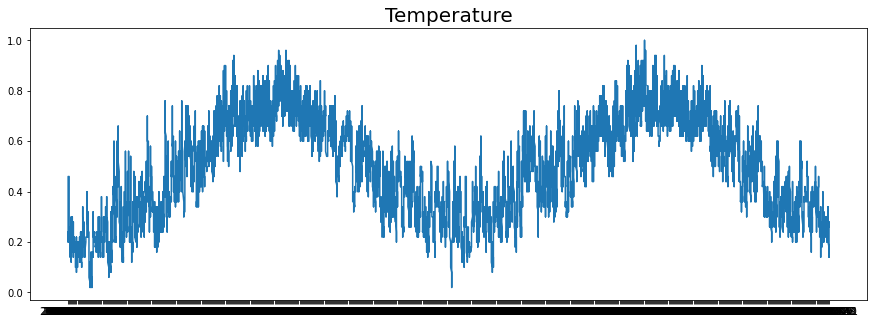

In [8]:
dates = data_train['dteday'].values
temp = data_train['temp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature', fontsize=20)

In [9]:
from sklearn.model_selection import train_test_split
date_latih, date_test, temp_latih, temp_test = train_test_split(dates, temp, test_size=.2, shuffle=False)

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
train_set = windowed_dataset(temp_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
   tf.keras.layers.LSTM(60, return_sequences=True),
   tf.keras.layers.LSTM(60),
   tf.keras.layers.Dense(30, activation="relu"),
   tf.keras.layers.Dense(10, activation="relu"),
   tf.keras.layers.Dense(1)
])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
minMae = (data_train['temp'].max() - data_train['temp'].min()) * .1

print(minMae)

0.098


In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<minMae) & (logs.get('val_mae')<minMae):
      print('\nProses dihentikan karena tingkat MAE sudah mencapai <10%!')
      self.model.stop_training = True

callbacks = myCallback()

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
    )
history = model.fit(
    train_set,
    epochs=100,
    validation_data=test_set,
    verbose=2,
    callbacks=[callbacks],
    )

Epoch 1/100
139/139 - 25s - loss: 0.1367 - mae: 0.4813 - val_loss: 0.0932 - val_mae: 0.3974 - 25s/epoch - 177ms/step
Epoch 2/100
139/139 - 20s - loss: 0.0887 - mae: 0.3752 - val_loss: 0.0644 - val_mae: 0.3198 - 20s/epoch - 141ms/step
Epoch 3/100
139/139 - 20s - loss: 0.0644 - mae: 0.3082 - val_loss: 0.0462 - val_mae: 0.2583 - 20s/epoch - 145ms/step
Epoch 4/100
139/139 - 18s - loss: 0.0486 - mae: 0.2594 - val_loss: 0.0343 - val_mae: 0.2132 - 18s/epoch - 128ms/step
Epoch 5/100
139/139 - 19s - loss: 0.0381 - mae: 0.2262 - val_loss: 0.0264 - val_mae: 0.1835 - 19s/epoch - 137ms/step
Epoch 6/100
139/139 - 19s - loss: 0.0310 - mae: 0.2033 - val_loss: 0.0212 - val_mae: 0.1647 - 19s/epoch - 134ms/step
Epoch 7/100
139/139 - 18s - loss: 0.0263 - mae: 0.1884 - val_loss: 0.0178 - val_mae: 0.1533 - 18s/epoch - 133ms/step
Epoch 8/100
139/139 - 20s - loss: 0.0232 - mae: 0.1786 - val_loss: 0.0157 - val_mae: 0.1462 - 20s/epoch - 145ms/step
Epoch 9/100
139/139 - 19s - loss: 0.0211 - mae: 0.1719 - val_los

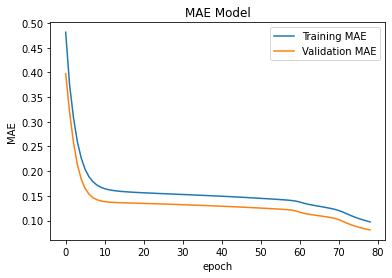

In [15]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['Training MAE', 'Validation MAE'], loc='upper right')
plt.show()

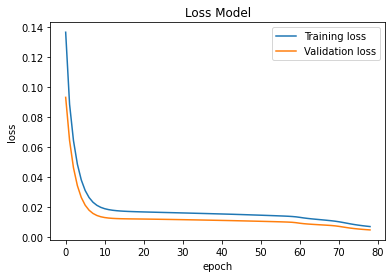

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()